# RTL-SDR Ultrasound Test
Copyright (C) 2018 William Meng

This file is part of rtl-ultrasound

rtl-ultrasound is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

rtl-ultrasound is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with rtl-ultrasound.  If not, see <http://www.gnu.org/licenses/>.

-------
William Meng K9TTL  
Aug 18, 2018

In this notebook, I will try to capture and plot some real data from the SimpleRick hardware.
The piezo transducer is placed in a box of water, ~~and is rotated back and forth with a servo motor.~~
For simplicity, in this experiment the piezo will be stationary.
Hopefully we'll see some echoes from the ultrasound waves reflecting off the plastic walls of the box.

Experimental setup:
![plastic box filled with water](DSCN7874.JPG)
![overall setup](DSCN7876.JPG)

What the echoes look like on the oscilloscope:
![echos, stationary](NewFile18.png)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from rtlsdr import *
from scipy.signal import resample
import time
from datetime import datetime
%matplotlib inline

## Configure settings for RTL-SDR

In [13]:
sdr = RtlSdr()

# configure device
sdr.set_direct_sampling(2) # directly sample Q channel
sdr.center_freq = 8e6
sdr.sample_rate = 2.4e6
sdr.gain = 'auto'

center_freq = sdr.center_freq
sample_rate = sdr.sample_rate
print("center freq = {} Hz".format(center_freq))
print("sample rate = {} Hz".format(sample_rate))
print("gain = {}".format(sdr.gain))

center freq = 8000000 Hz
sample rate = 2400000.0 Hz
gain = 0.0


## Acquire data and save to file

In [14]:
%%time
# read samples
samples = sdr.read_samples(256*10000)
sdr.close()

# save samples to disk with timestamp
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S')
np.save("rtlsdr_ultrasound_test_{}".format(timestamp), samples)

CPU times: user 580 ms, sys: 181 ms, total: 761 ms
Wall time: 2.14 s


## Load data from file and plot

[-0.00392157+0.00392157j -0.00392157-0.00392157j  0.00392157-0.00392157j
 ..., -0.00392157+0.00392157j  0.00392157-0.00392157j
  0.00392157-0.00392157j]
Found 2560000 samples


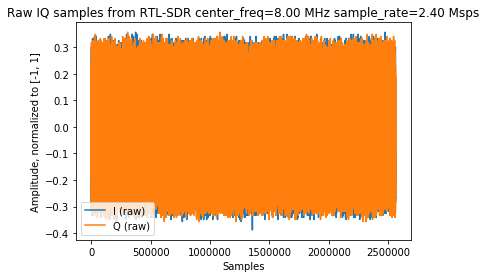

CPU times: user 10.9 s, sys: 840 ms, total: 11.8 s
Wall time: 12.8 s


In [16]:
%%time
samples = np.load("rtlsdr_ultrasound_test_2018-08-18_19:15:04.npy")
print(samples)
print("Found {} samples".format(len(samples)))
I_raw = np.real(samples)
Q_raw = np.imag(samples)
plt.plot(I_raw, label="I (raw)")
plt.plot(Q_raw, label="Q (raw)")
plt.title("Raw IQ samples from RTL-SDR center_freq=%.2f MHz sample_rate=%.2f Msps" % (center_freq/1e6, sample_rate/1e6))
plt.xlabel("Samples")
plt.ylabel("Amplitude, normalized to [-1, 1]")
plt.legend()
plt.show()

## Process signal
### Upsample and generate time base

In [17]:
%%time
upsampling_factor = 10
resampled = resample(samples, len(samples) * upsampling_factor)
fs = sample_rate * upsampling_factor
Ts = 1e6/fs # time per sample after resampling, in microseconds
print("Resampled at:")
print("fs = %.2f Msps" % (fs/1e6))
print("Ts = {} microseconds".format(Ts))
t = np.array([ x * Ts for x in range(len(resampled))]) # time base, in microseconds

Resampled at:
fs = 24.00 Msps
Ts = 0.041666666666666664 microseconds
CPU times: user 7.25 s, sys: 1.85 s, total: 9.1 s
Wall time: 10.8 s


### Plot envelope

In [18]:
%%time
envelope = np.abs(resampled)
t_ms = t/1000
#plt.plot(t_ms, envelope, label="envelope")
#plt.xlabel('t (milliseconds)')
#plt.ylabel('amplitude')
#plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
#          (center_freq/1.0e6, sample_rate/1.0e6))
#plt.legend()
#plt.show()

CPU times: user 356 ms, sys: 269 ms, total: 625 ms
Wall time: 821 ms


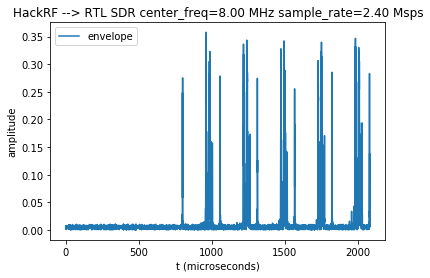

CPU times: user 268 ms, sys: 22.5 ms, total: 291 ms
Wall time: 339 ms


In [20]:
%%time
start = 0
end = 50000
zoomed_envelope = envelope[start:end]
zoomed_t = t[start:end]
plt.plot(zoomed_t, zoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

For some reason, it seems that the first 750 samples or so are always nearly zero.
Perhaps it takes some time to initialize the ADC hardware in the RTL-SDR,
so the first few packets it sends are zero values.

~~Also notice that the first peak in the data is NOT a Tx pulse, but rather an echo.
This raises an issue with the triggering algorithm, because the first trigger
will be on a peak other than the Tx pulse, and due to the trigger holdoff,
all subsequent triggers will be "poisoned" by the initial false trigger.~~
*Actually, the first peak is indeed a Tx pulse, but it has a smaller amplitude than
some of the echoes, which can still cause issues because the trigger threshold
is a fraction of the maximum valued sample.*

There are a couple ways to workaround this issue:
1. Make sure that the pulser does not start sending Tx pulses until *after* the
RTL-SDR has started sampling data. That guarantees that the first peak seen
by the RTL-SDR will be a Tx pulse.
* Increase the dead time to be large in proportion to the scanline time,
and set the trigger holdoff time to be slightly large than the scanline time
yet much smaller than the overall scanline+dead time.
The long dead time will ensure that the next trigger will be correct, even if the first trigger was wrong.

Option 1 is a good option when serial communication between rtlsdr_ultrasound and SimpleRick firmware is possible.

Option 2 is a good fallback when serial communication is not possible.

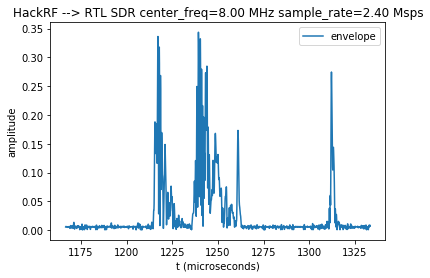

CPU times: user 185 ms, sys: 18 ms, total: 203 ms
Wall time: 206 ms


In [21]:
%%time
start1 = 28000
end1 = 32000
megazoomed_envelope = envelope[start1:end1]
megazoomed_t = t[start1:end1]
plt.plot(megazoomed_t, megazoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

## Construct image

To construct a 2D ultrasound image, we need to slice the 1D ultrasound signal into individual scan lines.
This can be done by setting a an appropriate threhold amplitude for identifying a trigger pulse,
and the minimum time for a scan line so as to prevent slicing the signal in the middle of a scan line.
This is exactly analogous to the trigger level and trigger holdoff settings on an oscilloscope.

### Set trigger level and holdoff

In [22]:
%%time
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = 0.7 * max_envelope
print("Trigger level = {}".format(trigger_level))

#plt.plot(t_ms, envelope, label="envelope")
#plt.plot(t_ms, [trigger_level] * len(t_ms), label="trigger level")
#plt.xlabel('t (milliseconds)')
#plt.ylabel('amplitude')
#plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
#          (center_freq/1.0e6, sample_rate/1.0e6))
#plt.legend()
#plt.show()

max(envelope) = 0.4368930655983821
Trigger level = 0.30582514591886745
CPU times: user 55.3 ms, sys: 155 ms, total: 210 ms
Wall time: 217 ms


In [23]:
%%time
trigger_holdoff_us = 130 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

Trigger holdoff = 130 microseconds = 3120 samples
CPU times: user 97 µs, sys: 42 µs, total: 139 µs
Wall time: 145 µs


### Slice into scan lines
Now let's iteratively identify the slicing points, and plot the first few.

In [24]:
%%time
prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
for i in range(len(envelope)):
    if i >= prev_trigger + trigger_holdoff:
        if envelope[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

print("Slicing at indices {}".format(slice_indices))
print("Triggered {} times".format(len(slice_indices)))

# Visualize where the slicing happens
slice_lines = np.zeros(len(envelope))
"""
# this is extremely slow, because the numpy array has to be copied in memory for each substitution
for i in range(len(slice_lines)):
    if i in slice_indices:
        slice_lines[i] = -0.1
"""
# faster method:
slice_lines[slice_indices] = -0.1

#plt.plot(t_ms, envelope, label="envelope")
#plt.plot(t_ms, [trigger_level] * len(t_ms), label="trigger level")
#plt.plot(t_ms, slice_lines, label="slice lines")
#plt.xlabel('t (milliseconds)')
#plt.ylabel('amplitude')
#plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
#          (center_freq/1.0e6, sample_rate/1.0e6))
#plt.legend()
#plt.show()

Slicing at indices [23055, 29210, 35349, 41463, 47599, 53774, 59920, 66020, 72156, 78269, 84388, 90504, 96686, 102783, 108887, 114991, 121135, 127236, 133375, 139516, 145608, 151709, 157885, 163954, 170092, 176186, 182324, 188436, 194579, 200668, 206805, 212928, 219052, 225154, 231299, 237401, 243543, 249633, 255775, 261888, 268026, 274118, 280301, 286445, 292599, 298756, 305448, 311062, 317759, 323367, 329480, 335623, 341783, 347920, 354075, 360179, 366277, 372401, 378523, 384662, 390765, 396889, 403005, 409144, 415237, 421379, 427488, 433626, 439735, 445871, 451981, 458122, 464207, 470343, 476463, 482601, 488684, 494821, 500948, 507068, 513169, 519313, 525414, 531553, 537654, 543794, 549912, 556564, 562143, 568312, 574453, 580632, 586765, 592948, 599091, 605249, 611383, 617505, 623633, 629811, 635940, 642062, 648200, 654298, 660954, 666539, 672676, 678813, 684905, 691063, 697155, 703266, 709919, 715516, 721640, 727738, 733876, 739985, 746121, 752229, 758368, 764470, 770614, 776711, 7

Intervals between each trigger are [6155 6139 6114 ..., 5584 6102 6139]
Choosing the minimum, 5454, as the length of each scan line
Not enough samples left for a complete scan line!
Created 4166 scan lines


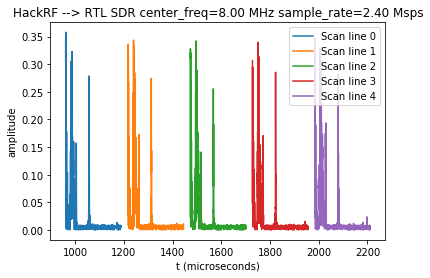

CPU times: user 378 ms, sys: 42.2 ms, total: 420 ms
Wall time: 442 ms


In [25]:
%%time
# slice array and vstack
diffs = np.diff(slice_indices)
min_diff = np.min(diffs)
print("Intervals between each trigger are {}".format(diffs))
print("Choosing the minimum, {}, as the length of each scan line".format(min_diff))

scan_lines = list()
for index in slice_indices:
    if len(envelope) < index + min_diff:
        print("Not enough samples left for a complete scan line!")
        continue
    scan_line = envelope[index:index+min_diff]
    scan_lines.append(scan_line)

print("Created {} scan lines".format(len(scan_lines)))

# Plot first 5 scan lines
for i in range(5):
    index = slice_indices[i]
    plt.plot(t[index:index+min_diff], scan_lines[i], label="Scan line {}".format(i))
 
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
      (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

Notice that it incorrectly triggers on the first echo, rather than the Tx pulse.
Since the piezo is stationary, we can still construct an image, even though it will look like
the top is chopped off and moved to the bottom.

### Stack scan lines into image
Use numpy.vstack(), then (optionally) crop the 2D array to get rid of some blank space.

Image dimensions: (4166, 5454)


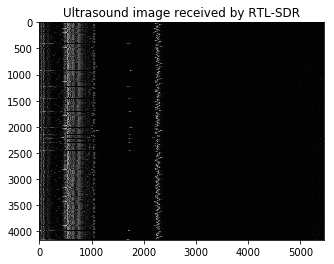

CPU times: user 751 ms, sys: 405 ms, total: 1.16 s
Wall time: 1.22 s


In [27]:
%%time
image = np.vstack(tuple(scan_lines))
print("Image dimensions: {}".format(image.shape))
plt.imshow(image, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR")
plt.show()

### Crop and repeat image for easier viewing

In [28]:
# save 2D array to disk
np.save("rtlsdr_image_2018-08-18_19:15:04.npy", image)

### Polar to Cartesian mapping

See [previous experiment](../20180813/rtlsdr_ultrasound_test.ipynb) for explanation.

In [29]:
image = np.load("rtlsdr_image_2018-08-18_19:15:04.npy")

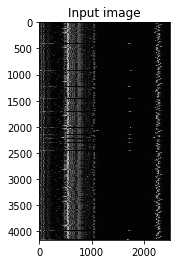

2652.157971683344 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 2083 above and 10415 below


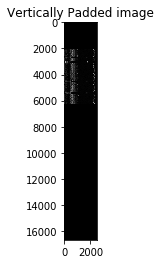

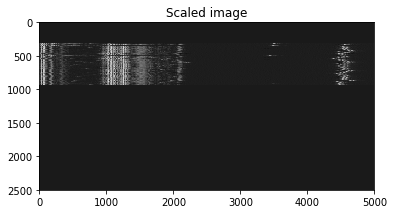

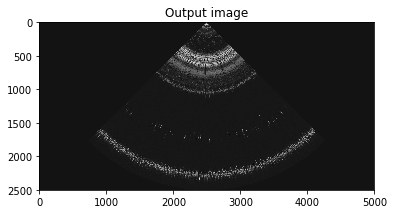

CPU times: user 2.95 s, sys: 1.51 s, total: 4.46 s
Wall time: 4.5 s


In [33]:
%%time
import cv2

maxRadius = 2500
im_in = image[:, :maxRadius] # cut off any data beyond maxRadius
plt.imshow(im_in, cmap='gray')
plt.title("Input image")
plt.show()

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius))
im_above = np.zeros((pad_above, maxRadius))

padded_image = np.vstack((im_above, im_in, im_below))
plt.imshow(padded_image, cmap='gray')
plt.title("Vertically Padded image")
plt.show()

# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)
plt.imshow(scaled_image, cmap='gray')
plt.title("Scaled image")
plt.show()

# transform image
center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

TODO:
* create mask so the image looks prettier
* horizontally pad on the left according to $r_{min}$

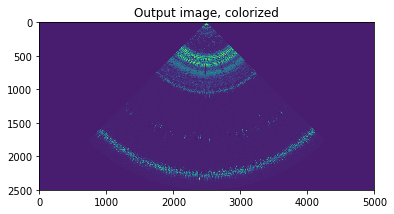

In [34]:
plt.imshow(im_out)
plt.title("Output image, colorized")
plt.show()

In [38]:
# save 2D array of polar2cart image to disk
np.save("rtlsdr_polar2cart_2018-08-18_19:15:04.npy", im_out)
# warning: this file is quite large! ~100MB

## Fix false triggering

~~We can fix the false triggering by manually discarding some samples at the beginning,
so that the first peak is actually a Tx pulse.~~

In [50]:
%%time
time_to_cut = 790 # amount of time to cut, in microseconds
samples_to_cut = int(time_to_cut / Ts) # how many samples to cut
resampled_cut = resampled[samples_to_cut:]
print("Cut {} samples from {}, yielding {} samples.".format(samples_to_cut, len(resampled), len(resampled_cut)))

Cut 19200 samples from 25600000, yielding 25580800 samples.
CPU times: user 271 µs, sys: 98 µs, total: 369 µs
Wall time: 351 µs


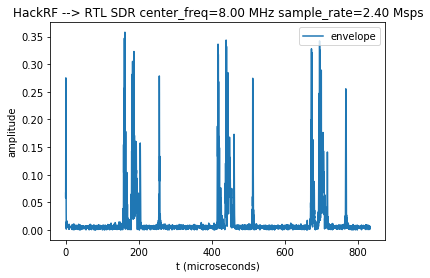

CPU times: user 4.39 s, sys: 810 ms, total: 5.2 s
Wall time: 5.71 s


In [51]:
%%time
t_cut = np.array([ x * Ts for x in range(len(resampled_cut))]) # time base, in microseconds
envelope_cut = np.abs(resampled_cut)

start = 0
end = 20000
zoomed_envelope_cut = envelope_cut[start:end]
zoomed_t_cut = t_cut[start:end]
plt.plot(zoomed_t_cut, zoomed_envelope_cut, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

Actually, we just need to set a lower trigger level because the Tx pulses have a smaller amplitude than the echoes.
Also increasing trigger holdoff time to be greater than TGC time, because some of the large echoes appear near the end of the TGC time.

max(envelope) = 0.4368930655983821
Trigger level = 0.17475722623935286
Trigger holdoff = 220 microseconds = 5280 samples
Triggered 4175 times
Choosing the minimum diff, 6062, as the length of each scan line
Not enough samples left for a complete scan line!
Created 4174 scan lines


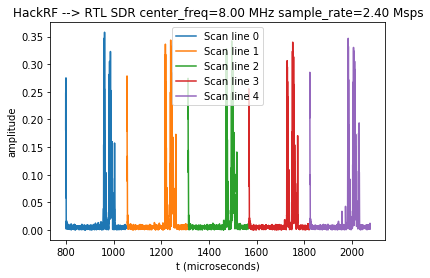

CPU times: user 4.86 s, sys: 54.1 ms, total: 4.91 s
Wall time: 5.07 s


In [56]:
%%time
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = 0.4 * max_envelope
print("Trigger level = {}".format(trigger_level))
trigger_holdoff_us = 220 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
for i in range(len(envelope)):
    if i >= prev_trigger + trigger_holdoff:
        if envelope[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

#print("Slicing at indices {}".format(slice_indices))
print("Triggered {} times".format(len(slice_indices)))

# slice array and vstack
diffs = np.diff(slice_indices)
min_diff = np.min(diffs)
#print("Intervals between each trigger are {}".format(diffs))
print("Choosing the minimum diff, {}, as the length of each scan line".format(min_diff))

scan_lines = list()
for index in slice_indices:
    if len(envelope) < index + min_diff:
        print("Not enough samples left for a complete scan line!")
        continue
    scan_line = envelope[index:index+min_diff]
    scan_lines.append(scan_line)

print("Created {} scan lines".format(len(scan_lines)))

# Plot first 5 scan lines
for i in range(5):
    index = slice_indices[i]
    plt.plot(t[index:index+min_diff], scan_lines[i], label="Scan line {}".format(i))
 
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
      (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

Image dimensions: (4174, 6062)


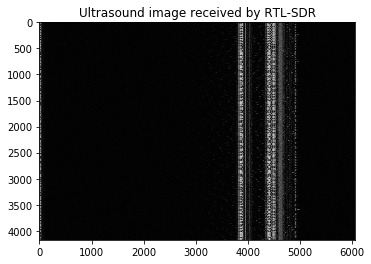

CPU times: user 877 ms, sys: 505 ms, total: 1.38 s
Wall time: 1.49 s


In [57]:
%%time
image = np.vstack(tuple(scan_lines))
print("Image dimensions: {}".format(image.shape))
plt.imshow(image, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR")
plt.show()

In [67]:
%%time
import cv2

max_depth_cm = 32 # maximum round trip distance for ultrasound wave to travel
v = 1498 # speed of sound in water (meters per second)
v_cm_us = v*100/1e6 # speed of sound in water (cm per microsecond)
max_depth_time = max_depth_cm / v_cm_us # how many microseconds to keep in each scan line
max_depth_samples = int(max_depth_time / Ts) # how many samples to keep in each scan line
print("Max depth = {} cm = {} µs = {} samples".format(max_depth_cm, max_depth_time, max_depth_samples))
im_in = image[:, :max_depth_samples] # cut off any data beyond max depth

Max depth = 32 cm = 213.6181575433912 µs = 5126 samples
CPU times: user 130 µs, sys: 30 µs, total: 160 µs
Wall time: 169 µs


maxRadius = 5126 pixels


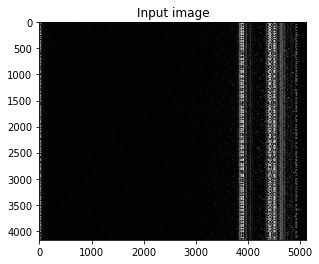

2657.2509298622845 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 2087 above and 10435 below


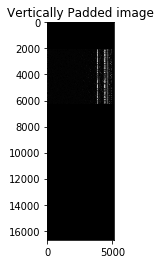

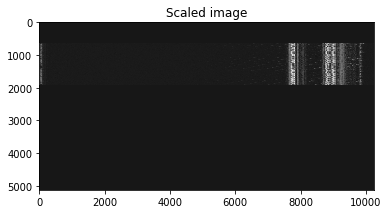

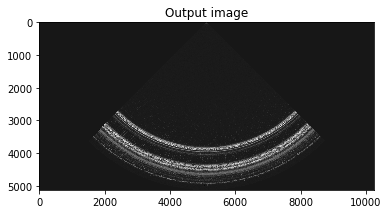

CPU times: user 9.02 s, sys: 5.42 s, total: 14.4 s
Wall time: 16.3 s


In [70]:
%%time
maxRadius = im_in.shape[1]
print("maxRadius = {} pixels".format(maxRadius))

plt.imshow(im_in, cmap='gray')
plt.title("Input image")
plt.show()

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius))
im_above = np.zeros((pad_above, maxRadius))

padded_image = np.vstack((im_above, im_in, im_below))
plt.imshow(padded_image, cmap='gray')
plt.title("Vertically Padded image")
plt.show()

# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)
plt.imshow(scaled_image, cmap='gray')
plt.title("Scaled image")
plt.show()

# transform image
center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

## Optimizing performance

* t should be iterator instead of numpy array
* use int instead of float in numpy arrays
* avoid unecessary printing of long data
* avoid unecessary plotting of data

maxRadius = 5126 pixels
2657.2509298622845 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 2087 above and 10435 below


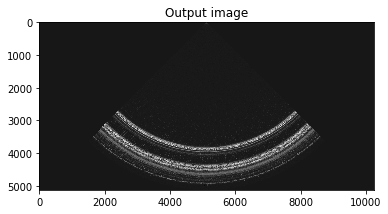

CPU times: user 4.76 s, sys: 3.36 s, total: 8.12 s
Wall time: 8.31 s


In [119]:
%%time
# since pyplot is very slow with large arrays, let's plot only the final result
maxRadius = im_in.shape[1]
print("maxRadius = {} pixels".format(maxRadius))

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius))
im_above = np.zeros((pad_above, maxRadius))

padded_image = np.vstack((im_above, im_in, im_below))
# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)

# transform image
center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

Woohoo! We saved 8 seconds by not plotting 3 images.
What if we don't even plot the final image?

In [120]:
%%time
maxRadius = im_in.shape[1]
print("maxRadius = {} pixels".format(maxRadius))

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius))
im_above = np.zeros((pad_above, maxRadius))

padded_image = np.vstack((im_above, im_in, im_below))
# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)

# transform image
center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)

maxRadius = 5126 pixels
2657.2509298622845 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 2087 above and 10435 below
CPU times: user 2.59 s, sys: 1.91 s, total: 4.5 s
Wall time: 3.18 s


Wow! We saved another 5 seconds. Perhaps there are alternative libraries to quickly render images from 2D numpy arrays?

In [122]:
%%time
cv2.imshow('output', im_out)
cv2.waitKey(0)
cv2.destroyAllWindows()

CPU times: user 8.32 s, sys: 5.01 s, total: 13.3 s
Wall time: 11.4 s


Apparently cv2.imshow has to open a separate graphical window rather than rendering inline, and only showed a black screen.

In [124]:
type(im_out[0, 0])

numpy.float64

Aha! Here's a performance killer: using float instead of int in the numpy arrays.
Really, we should use int for all of the signal processing.
Since all the data will be positive in the envelope, we can use unsigned integers.
Although the original IQ data from the RTL-SDR is uint8, we may need finer resolution after resampling.
So let's use uint16.

## Speedup by using uint16 instead of float64

In [125]:
%%time
upsampling_factor = 10
resampled = resample(samples, len(samples) * upsampling_factor)
fs = sample_rate * upsampling_factor
Ts = 1e6/fs # time per sample after resampling, in microseconds
print("Resampled at:")
print("fs = %.2f Msps" % (fs/1e6))
print("Ts = {} microseconds".format(Ts))
print("Type of resampled data: {}".format(type(resampled[0])))
t = np.array([ x * Ts for x in range(len(resampled))]) # time base, in microseconds

Resampled at:
fs = 24.00 Msps
Ts = 0.041666666666666664 microseconds
Type of resampled data: <class 'numpy.complex128'>
CPU times: user 6.29 s, sys: 2.49 s, total: 8.78 s
Wall time: 9.36 s


In [126]:
%%time
envelope = np.abs(resampled).astype('uint16')
print("Type of envelope data: {}".format(type(envelope[0])))
print(envelope)

Type of envelope data: <class 'numpy.uint16'>
[0 0 0 ..., 0 0 0]
CPU times: user 199 ms, sys: 146 ms, total: 345 ms
Wall time: 345 ms


Oops! We can't just cast the type to uint16 without scaling, as the float values between 0 and 1 will all be rounded down to zero.

In [127]:
%%time
envelope = np.multiply(np.abs(resampled), 2**16).astype('uint16')
print("Type of envelope data: {}".format(type(envelope[0])))
print(envelope)

Type of envelope data: <class 'numpy.uint16'>
[363 399 420 ..., 182 253 314]
CPU times: user 286 ms, sys: 262 ms, total: 548 ms
Wall time: 548 ms


max(envelope) = 28632
Trigger level = 11452
Trigger holdoff = 220 microseconds = 5280 samples
Triggered 4175 times
Choosing the minimum diff, 6062, as the length of each scan line
Not enough samples left for a complete scan line!
Created 4174 scan lines


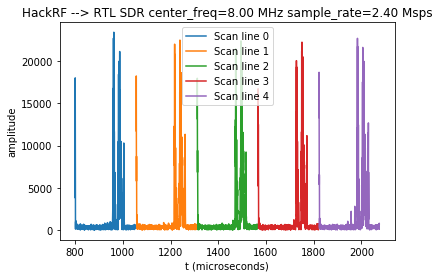

CPU times: user 11.1 s, sys: 99.1 ms, total: 11.2 s
Wall time: 11.4 s


In [128]:
%%time
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = int(0.4 * max_envelope)
print("Trigger level = {}".format(trigger_level))
trigger_holdoff_us = 220 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
for i in range(len(envelope)):
    if i >= prev_trigger + trigger_holdoff:
        if envelope[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

#print("Slicing at indices {}".format(slice_indices))
print("Triggered {} times".format(len(slice_indices)))

# slice array and vstack
diffs = np.diff(slice_indices)
min_diff = np.min(diffs)
#print("Intervals between each trigger are {}".format(diffs))
print("Choosing the minimum diff, {}, as the length of each scan line".format(min_diff))

scan_lines = list()
for index in slice_indices:
    if len(envelope) < index + min_diff:
        print("Not enough samples left for a complete scan line!")
        continue
    scan_line = envelope[index:index+min_diff]
    scan_lines.append(scan_line)

print("Created {} scan lines".format(len(scan_lines)))

# Plot first 5 scan lines
for i in range(5):
    index = slice_indices[i]
    plt.plot(t[index:index+min_diff], scan_lines[i], label="Scan line {}".format(i))
 
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
      (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

Type of image pixels: <class 'numpy.uint16'>
Image dimensions: (4174, 6062)


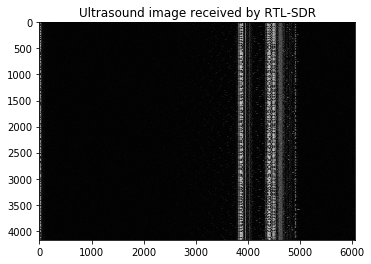

Max depth = 32 cm = 213.6181575433912 µs = 5126 samples
CPU times: user 679 ms, sys: 206 ms, total: 885 ms
Wall time: 893 ms


In [129]:
%%time
image = np.vstack(tuple(scan_lines))
print("Type of image pixels: {}".format(type(image[0, 0])))
print("Image dimensions: {}".format(image.shape))
plt.imshow(image, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR")
plt.show()

max_depth_cm = 32 # maximum round trip distance for ultrasound wave to travel
v = 1498 # speed of sound in water (meters per second)
v_cm_us = v*100/1e6 # speed of sound in water (cm per microsecond)
max_depth_time = max_depth_cm / v_cm_us # how many microseconds to keep in each scan line
max_depth_samples = int(max_depth_time / Ts) # how many samples to keep in each scan line
print("Max depth = {} cm = {} µs = {} samples".format(max_depth_cm, max_depth_time, max_depth_samples))
im_in = image[:, :max_depth_samples] # cut off any data beyond max depth

In [134]:
%%time
import cv2

maxRadius = im_in.shape[1]
print("maxRadius = {} pixels".format(maxRadius))

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius), dtype='uint16')
im_above = np.zeros((pad_above, maxRadius), dtype='uint16')

padded_image = np.vstack((im_above, im_in, im_below))
# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)

# transform image
center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)

maxRadius = 5126 pixels
2657.2509298622845 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 2087 above and 10435 below
CPU times: user 1.23 s, sys: 975 ms, total: 2.2 s
Wall time: 1.7 s


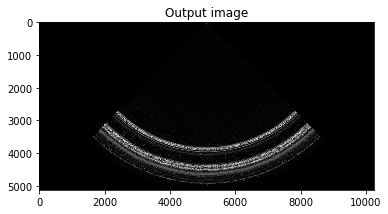

CPU times: user 1.13 s, sys: 528 ms, total: 1.65 s
Wall time: 1.69 s


In [135]:
%%time
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

In [136]:
print(type(im_below[0, 0]))
print(type(im_above[0, 0]))
print(type(padded_image[0, 0]))
print(type(scaled_image[0, 0]))
print(type(im_out[0, 0]))

<class 'numpy.uint16'>
<class 'numpy.uint16'>
<class 'numpy.uint16'>
<class 'numpy.uint16'>
<class 'numpy.uint16'>


Nice, this is a lot faster! Can we go even faster with uint8?

## Speedup by using uint8 instead of float64

In [137]:
%%time
upsampling_factor = 10
resampled = resample(samples, len(samples) * upsampling_factor)
fs = sample_rate * upsampling_factor
Ts = 1e6/fs # time per sample after resampling, in microseconds
print("Resampled at:")
print("fs = %.2f Msps" % (fs/1e6))
print("Ts = {} microseconds".format(Ts))
print("Type of resampled data: {}".format(type(resampled[0])))
t = np.array([ x * Ts for x in range(len(resampled))]) # time base, in microseconds

Resampled at:
fs = 24.00 Msps
Ts = 0.041666666666666664 microseconds
Type of resampled data: <class 'numpy.complex128'>
CPU times: user 6.13 s, sys: 1.19 s, total: 7.32 s
Wall time: 7.85 s


In [138]:
%%time
envelope = np.multiply(np.abs(resampled), 2**8).astype('uint8')
print("Type of envelope data: {}".format(type(envelope[0])))
print(envelope)

Type of envelope data: <class 'numpy.uint8'>
[1 1 1 ..., 0 0 1]
CPU times: user 289 ms, sys: 253 ms, total: 542 ms
Wall time: 541 ms


max(envelope) = 111
Trigger level = 44
Trigger holdoff = 220 microseconds = 5280 samples
Triggered 4175 times
Choosing the minimum diff, 6062, as the length of each scan line
Not enough samples left for a complete scan line!
Created 4174 scan lines


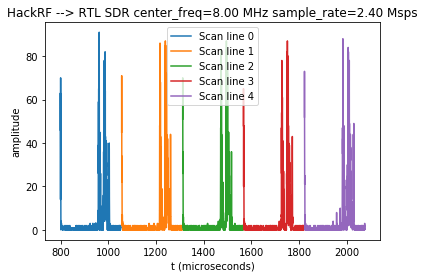

CPU times: user 9.89 s, sys: 54.3 ms, total: 9.95 s
Wall time: 10 s


In [139]:
%%time
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = int(0.4 * max_envelope)
print("Trigger level = {}".format(trigger_level))
trigger_holdoff_us = 220 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
for i in range(len(envelope)):
    if i >= prev_trigger + trigger_holdoff:
        if envelope[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

#print("Slicing at indices {}".format(slice_indices))
print("Triggered {} times".format(len(slice_indices)))

# slice array and vstack
diffs = np.diff(slice_indices)
min_diff = np.min(diffs)
#print("Intervals between each trigger are {}".format(diffs))
print("Choosing the minimum diff, {}, as the length of each scan line".format(min_diff))

scan_lines = list()
for index in slice_indices:
    if len(envelope) < index + min_diff:
        print("Not enough samples left for a complete scan line!")
        continue
    scan_line = envelope[index:index+min_diff]
    scan_lines.append(scan_line)

print("Created {} scan lines".format(len(scan_lines)))

# Plot first 5 scan lines
for i in range(5):
    index = slice_indices[i]
    plt.plot(t[index:index+min_diff], scan_lines[i], label="Scan line {}".format(i))
 
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
      (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

Type of image pixels: <class 'numpy.uint8'>
Image dimensions: (4174, 6062)


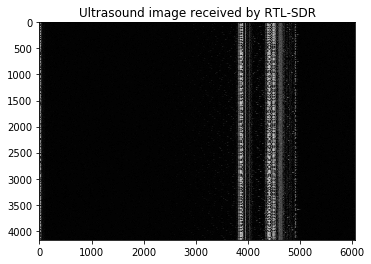

Max depth = 32 cm = 213.6181575433912 µs = 5126 samples
CPU times: user 767 ms, sys: 180 ms, total: 946 ms
Wall time: 947 ms


In [140]:
%%time
image = np.vstack(tuple(scan_lines))
print("Type of image pixels: {}".format(type(image[0, 0])))
print("Image dimensions: {}".format(image.shape))
plt.imshow(image, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR")
plt.show()

max_depth_cm = 32 # maximum round trip distance for ultrasound wave to travel
v = 1498 # speed of sound in water (meters per second)
v_cm_us = v*100/1e6 # speed of sound in water (cm per microsecond)
max_depth_time = max_depth_cm / v_cm_us # how many microseconds to keep in each scan line
max_depth_samples = int(max_depth_time / Ts) # how many samples to keep in each scan line
print("Max depth = {} cm = {} µs = {} samples".format(max_depth_cm, max_depth_time, max_depth_samples))
im_in = image[:, :max_depth_samples] # cut off any data beyond max depth

In [141]:
%%time
import cv2

maxRadius = im_in.shape[1]
print("maxRadius = {} pixels".format(maxRadius))

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius), dtype='uint8')
im_above = np.zeros((pad_above, maxRadius), dtype='uint8')

padded_image = np.vstack((im_above, im_in, im_below))
# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)

# transform image
center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)

maxRadius = 5126 pixels
2657.2509298622845 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 2087 above and 10435 below
CPU times: user 1.2 s, sys: 495 ms, total: 1.7 s
Wall time: 1.22 s


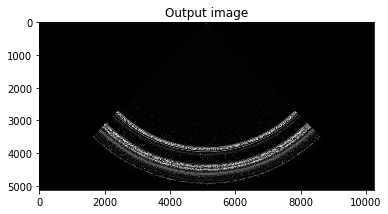

CPU times: user 1.18 s, sys: 429 ms, total: 1.61 s
Wall time: 1.62 s


In [142]:
%%time
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

In [143]:
print(type(im_below[0, 0]))
print(type(im_above[0, 0]))
print(type(padded_image[0, 0]))
print(type(scaled_image[0, 0]))
print(type(im_out[0, 0]))

<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>


Only a small performance increase, at the expensive of half the dynamic range. Seems like uint16 is a better option.

## Some more cuts
Let's try to make it as fast as possible, so skip plotting the intermediate steps,
and only print vital information.

In [147]:
%%time
samples = np.load("rtlsdr_ultrasound_test_2018-08-18_19:15:04.npy")
upsampling_factor = 10
resampled = resample(samples, len(samples) * upsampling_factor)
fs = sample_rate * upsampling_factor
Ts = 1e6/fs # time per sample after resampling, in microseconds
print("Resampled at:")
print("fs = %.2f Msps" % (fs/1e6))
print("Ts = {} microseconds".format(Ts))
print("Type of resampled data: {}".format(type(resampled[0])))

Resampled at:
fs = 24.00 Msps
Ts = 0.041666666666666664 microseconds
Type of resampled data: <class 'numpy.complex128'>
CPU times: user 2.1 s, sys: 485 ms, total: 2.59 s
Wall time: 2.62 s


In [149]:
%%time
envelope = np.multiply(np.abs(resampled), 2**16).astype('uint16')
print("Type of envelope data: {}".format(type(envelope[0])))
print(envelope[0])

Type of envelope data: <class 'numpy.uint16'>
363
CPU times: user 274 ms, sys: 262 ms, total: 536 ms
Wall time: 535 ms


In [150]:
%%time
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = int(0.4 * max_envelope)
print("Trigger level = {}".format(trigger_level))
trigger_holdoff_us = 220 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
for i in range(len(envelope)):
    if i >= prev_trigger + trigger_holdoff:
        if envelope[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

#print("Slicing at indices {}".format(slice_indices))
print("Triggered {} times".format(len(slice_indices)))

# slice array and vstack
diffs = np.diff(slice_indices)
min_diff = np.min(diffs)
#print("Intervals between each trigger are {}".format(diffs))
print("Choosing the minimum diff, {}, as the length of each scan line".format(min_diff))

scan_lines = list()
for index in slice_indices:
    if len(envelope) < index + min_diff:
        print("Not enough samples left for a complete scan line!")
        continue
    scan_line = envelope[index:index+min_diff]
    scan_lines.append(scan_line)

print("Created {} scan lines".format(len(scan_lines)))

max(envelope) = 28632
Trigger level = 11452
Trigger holdoff = 220 microseconds = 5280 samples
Triggered 4175 times
Choosing the minimum diff, 6062, as the length of each scan line
Not enough samples left for a complete scan line!
Created 4174 scan lines
CPU times: user 9.81 s, sys: 42.6 ms, total: 9.86 s
Wall time: 9.9 s


Uh oh, the slicing and stacking is quite slow. Let's try to optimize it.

In [154]:
%%time
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = int(0.4 * max_envelope)
print("Trigger level = {}".format(trigger_level))
trigger_holdoff_us = 220 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
for i in range(len(envelope)):
    if i >= prev_trigger + trigger_holdoff:
        if envelope[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

print("Triggered {} times".format(len(slice_indices)))

max(envelope) = 28632
Trigger level = 11452
Trigger holdoff = 220 microseconds = 5280 samples
Triggered 4175 times
CPU times: user 10.5 s, sys: 60.6 ms, total: 10.6 s
Wall time: 10.8 s


Looks like iterating through a large numpy array is really slow.
[According to StackOverflow](https://stackoverflow.com/a/40593934),
there is no fast way (compared to C) to iterate through a numpy array.
But maybe a list would be faster?

In [155]:
%%time
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = int(0.4 * max_envelope)
print("Trigger level = {}".format(trigger_level))
trigger_holdoff_us = 220 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
env_list = envelope.tolist()
print("env_list data type: {}".format(type(env_list[0])))
for i in range(len(env_list)):
    if i >= prev_trigger + trigger_holdoff:
        if env_list[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

print("Triggered {} times".format(len(slice_indices)))

max(envelope) = 28632
Trigger level = 11452
Trigger holdoff = 220 microseconds = 5280 samples
env_list data type: <class 'int'>
Triggered 4175 times
CPU times: user 5.53 s, sys: 675 ms, total: 6.21 s
Wall time: 6.89 s


It's a few seconds faster! Still not great, however. Maybe the comparisons are taking a long time?

In [159]:
%%time
# slice array and vstack
diffs = np.diff(slice_indices)
min_diff = np.min(diffs)
#print("Intervals between each trigger are {}".format(diffs))
print("Choosing the minimum diff, {}, as the length of each scan line".format(min_diff))

scan_lines = list()
for index in slice_indices:
    if len(envelope) < index + min_diff:
        print("Not enough samples left for a complete scan line!")
        continue
    scan_line = envelope[index:index+min_diff]
    scan_lines.append(scan_line)

print("Created {} scan lines".format(len(scan_lines)))

image = np.vstack(tuple(scan_lines))
print("Type of image pixels: {}".format(type(image[0, 0])))
print("Image dimensions: {}".format(image.shape))

max_depth_cm = 32 # maximum round trip distance for ultrasound wave to travel
v = 1498 # speed of sound in water (meters per second)
v_cm_us = v*100/1e6 # speed of sound in water (cm per microsecond)
max_depth_time = max_depth_cm / v_cm_us # how many microseconds to keep in each scan line
max_depth_samples = int(max_depth_time / Ts) # how many samples to keep in each scan line
print("Max depth = {} cm = {} µs = {} samples".format(max_depth_cm, max_depth_time, max_depth_samples))
im_in = image[:, :max_depth_samples] # cut off any data beyond max depth

Choosing the minimum diff, 6062, as the length of each scan line
Not enough samples left for a complete scan line!
Created 4174 scan lines
Type of image pixels: <class 'numpy.uint16'>
Image dimensions: (4174, 6062)
Max depth = 32 cm = 213.6181575433912 µs = 5126 samples
CPU times: user 42.1 ms, sys: 32 ms, total: 74.1 ms
Wall time: 75.7 ms


In [162]:
%%time
import cv2

maxRadius = im_in.shape[1]
print("maxRadius = {} pixels".format(maxRadius))

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius), dtype='uint16')
im_above = np.zeros((pad_above, maxRadius), dtype='uint16')

padded_image = np.vstack((im_above, im_in, im_below))
# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)

# transform image
center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)

maxRadius = 5126 pixels
2657.2509298622845 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 2087 above and 10435 below
CPU times: user 1.23 s, sys: 655 ms, total: 1.88 s
Wall time: 1.4 s


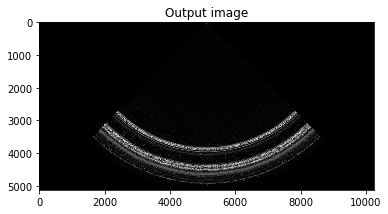

CPU times: user 1.18 s, sys: 562 ms, total: 1.74 s
Wall time: 1.76 s


In [163]:
%%time
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

## Putting it all together
Now let's do everything from samples to final image, and time it.

In [169]:
def generate_image(samples, verbose=False):
    upsampling_factor = 10
    resampled = resample(samples, len(samples) * upsampling_factor)
    fs = sample_rate * upsampling_factor
    Ts = 1e6/fs # time per sample after resampling, in microseconds
    envelope = np.multiply(np.abs(resampled), 2**16).astype('uint16')
    if verbose:
        print("Resampled at:")
        print("fs = %.2f Msps" % (fs/1e6))
        print("Ts = {} microseconds".format(Ts))
        print("Type of resampled data: {}".format(type(resampled[0])))
        print("Type of envelope data: {}".format(type(envelope[0])))
        print("First element of envelope: {}".format(envelope[0]))
    
    max_envelope = np.max(envelope)
    trigger_level = int(0.4 * max_envelope)
    trigger_holdoff_us = 220 # trigger holdoff time in microseconds
    trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
    if verbose:
        print("max(envelope) = {}".format(max_envelope))
        print("Trigger level = {}".format(trigger_level))
        print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))
    
    prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
    slice_indices = list()
    env_list = envelope.tolist()
    if verbose:
        print("env_list data type: {}".format(type(env_list[0])))
    for i in range(len(env_list)):
        if i >= prev_trigger + trigger_holdoff:
            if env_list[i] > trigger_level:
                slice_indices.append(i)
                prev_trigger = i
    
    if verbose:
        print("Triggered {} times".format(len(slice_indices)))
    
    # slice array and vstack
    diffs = np.diff(slice_indices)
    min_diff = np.min(diffs)
    if verbose:
        print("Choosing the minimum diff, {}, as the length of each scan line".format(min_diff))

    scan_lines = list()
    for index in slice_indices:
        if len(envelope) < index + min_diff: # not enough samples left for a complete scanline
            break

        scan_line = envelope[index:index+min_diff]
        scan_lines.append(scan_line)
    
    if verbose:
        print("Created {} scan lines".format(len(scan_lines)))
    
    image = np.vstack(tuple(scan_lines))
    if verbose:
        print("Type of image pixels: {}".format(type(image[0, 0])))
        print("Image dimensions: {}".format(image.shape))
    
    max_depth_cm = 32 # maximum round trip distance for ultrasound wave to travel
    v = 1498 # speed of sound in water (meters per second)
    v_cm_us = v*100/1e6 # speed of sound in water (cm per microsecond)
    max_depth_time = max_depth_cm / v_cm_us # how many microseconds to keep in each scan line
    max_depth_samples = int(max_depth_time / Ts) # how many samples to keep in each scan line
    if verbose:
        print("Max depth = {} cm = {} µs = {} samples".format(max_depth_cm, max_depth_time, max_depth_samples))
        
    im_in = image[:, :max_depth_samples] # cut off any data beyond max depth
    
    maxRadius = im_in.shape[1]
    
    angle_range = np.pi/2 # range of angle swept by transducer (radians)
    theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
    theta_min = 3/2*np.pi - angle_range/2
    theta_max = 3/2*np.pi + angle_range/2
    if verbose:
        print("maxRadius = {} pixels".format(maxRadius))
        print("{} rows per radian".format(theta_scale_factor))
        print("theta: [{}, {}] radians".format(theta_min, theta_max))
    
    # pad the image
    pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
    pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
    if verbose:
        print("Padding {} above and {} below".format(pad_above, pad_below))
        
    im_below = np.zeros((pad_below, maxRadius), dtype='uint16')
    im_above = np.zeros((pad_above, maxRadius), dtype='uint16')
    
    padded_image = np.vstack((im_above, im_in, im_below))
    # scale image
    scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)
    
    # transform image
    center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
    flags = cv2.WARP_INVERSE_MAP
    im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)
    
    return im_out

In [172]:
%%time
samples = np.load("rtlsdr_ultrasound_test_2018-08-18_19:15:04.npy")
im_out = generate_image(samples, verbose=True)

Resampled at:
fs = 24.00 Msps
Ts = 0.041666666666666664 microseconds
Type of resampled data: <class 'numpy.complex128'>
Type of envelope data: <class 'numpy.uint16'>
First element of envelope: 363
max(envelope) = 28632
Trigger level = 11452
Trigger holdoff = 220 microseconds = 5280 samples
env_list data type: <class 'int'>
Triggered 4175 times
Choosing the minimum diff, 6062, as the length of each scan line
Created 4174 scan lines
Type of image pixels: <class 'numpy.uint16'>
Image dimensions: (4174, 6062)
Max depth = 32 cm = 213.6181575433912 µs = 5126 samples
maxRadius = 5126 pixels
2657.2509298622845 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 2087 above and 10435 below
CPU times: user 8.83 s, sys: 2.29 s, total: 11.1 s
Wall time: 10.8 s


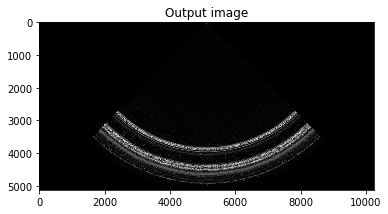

CPU times: user 1.14 s, sys: 532 ms, total: 1.68 s
Wall time: 1.71 s


In [173]:
%%time
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

In [174]:
%timeit im_out = generate_image(samples)

8.78 s ± 359 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


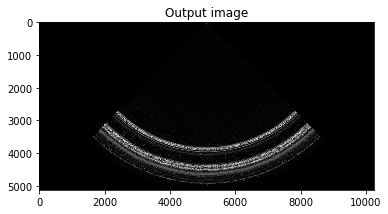

CPU times: user 1.17 s, sys: 485 ms, total: 1.66 s
Wall time: 1.72 s


In [175]:
%%time
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

From raw data to image in ~12 seconds... not bad for Python!

Next steps:
* put `generate_image()` in a script
* allow passing parameters as a dictionary, rather than hardcoding